# Fruit Classification using a ANN
link to [dataset](https://www.kaggle.com/datasets/sshikamaru/fruit-recognition/data)

In [1]:
%pip install kagglehub numpy Pillow scikit-learn torch torchvision matplotlib opencv-python 1>/dev/null
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
# Force CPU
# device = 'cpu'
print(f"Using {device} device")

%matplotlib inline


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: /home/pj/.pyenv/versions/py310_env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Using cuda device


/home/pj/.pyenv/versions/py310_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/pj/.cache/kagglehub/datasets/sshikamaru/fruit-recognition/versions/2


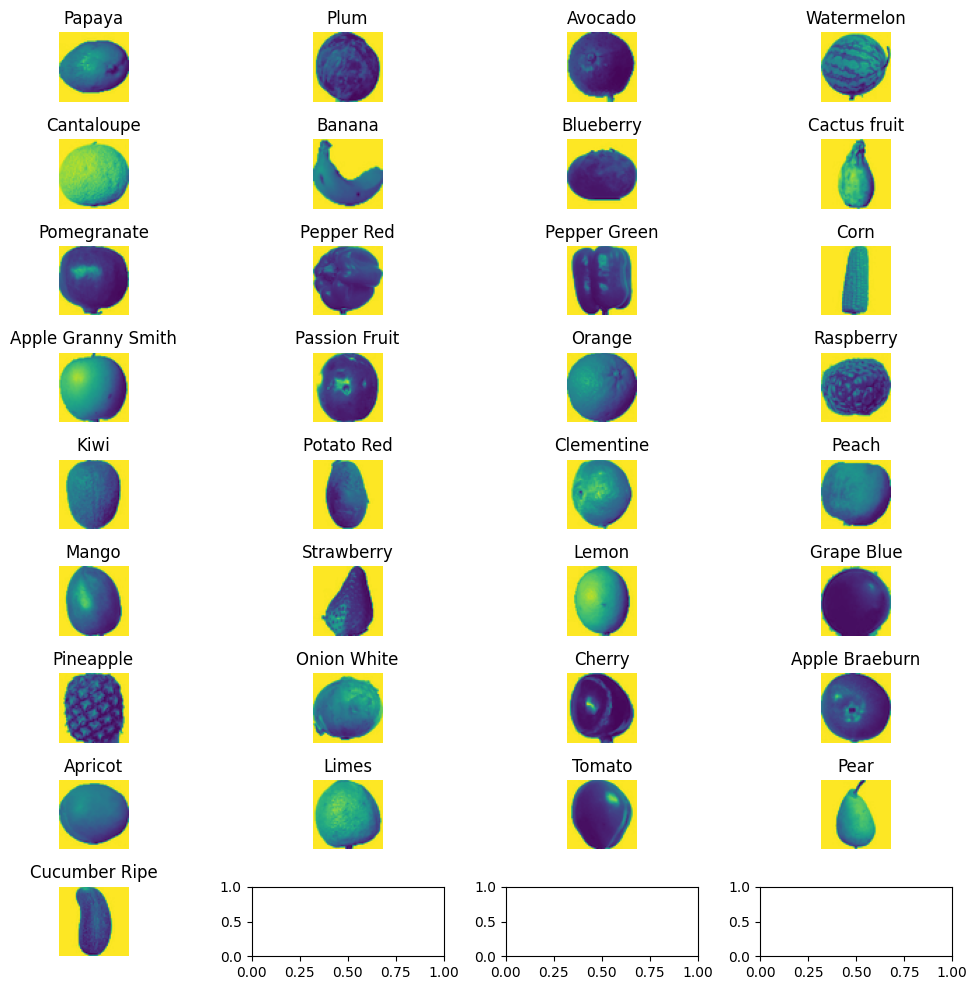

In [2]:
import kagglehub
from PIL import Image
import os

# Download the latest version of the dataset to the specified subdirectory.
dataset_path = kagglehub.dataset_download("sshikamaru/fruit-recognition")

print("Path to dataset files:", dataset_path)

# Load Training Data
fruit_img_map = {}
X_raw = []
y_raw = []
training_path = f"{dataset_path}/train/train"
for fruit_name in os.listdir(training_path):
    fruit_path = f"{training_path}/{fruit_name}"
    for img_fn in os.listdir(fruit_path):
        img_path = f"{fruit_path}/{img_fn}"
        img = Image.open(img_path)
        gray_img = img.convert("L")
        gray_img_resized = gray_img.resize((50, 50), Image.Resampling.LANCZOS)
        fruit_img_map[fruit_name] = gray_img_resized
        gray_array = np.array(gray_img_resized).flatten()
        X_raw.append(gray_array)
        y_raw.append(fruit_name)

# Load Validation Data
# TODO:

# Show some examples
n_images = len(fruit_img_map)
n_cols = 4
n_rows = (n_images + n_cols - 1) // n_cols  # rounds up if not evenly divisible

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
axes = axes.flatten()

for i, (fruit_name, fruit_img) in enumerate(fruit_img_map.items()):
    # Display the image in the subplot
    axes[i].imshow(fruit_img)
    axes[i].set_title(fruit_name)
    
    # Hide the axis ticks
    axes[i].axis('off')

plt.tight_layout()

In [3]:
!nvidia-smi

Fri Jan 31 22:29:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    On  |   00000000:01:00.0 Off |                  N/A |
|  0%   36C    P8              5W /  220W |      18MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms

# Assume X and y are already defined somewhere in your code.
# Convert X and y to NumPy arrays (if they aren't already)
X_arr = np.array(X_raw) / 255
y_arr_str = np.array(y_raw)

classes = sorted(set(y_arr_str)) 
print(f"{classes=}")

int_enc = np.vectorize(lambda c: classes.index(c))
y_arr = int_enc(y_arr_str)

print("X_arr shape:", X_arr.shape)
print("X_arr dtype:", X_arr.dtype)
print("First element:", X_arr[0])
print("Any NaN values?", np.isnan(X_arr).any())
print("All finite?", np.isfinite(X_arr).all())

# Convert NumPy arrays to torch tensors.
# Adjust the dtype if needed (e.g., torch.float32 for features, torch.long for labels).

dummy = torch.ones((10,), dtype=torch.float32)
dummy = dummy.to(device)

X_tensor = torch.from_numpy(X_arr).float().to(device)
y_tensor = torch.tensor(y_arr, dtype=torch.long).to(device)

# Create a TensorDataset from the tensors
dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for the training and test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for images, labels in train_loader:
    print("Batch images shape:", images.shape)
    print("Batch labels shape:", labels.shape)
    break

classes=[np.str_('Apple Braeburn'), np.str_('Apple Granny Smith'), np.str_('Apricot'), np.str_('Avocado'), np.str_('Banana'), np.str_('Blueberry'), np.str_('Cactus fruit'), np.str_('Cantaloupe'), np.str_('Cherry'), np.str_('Clementine'), np.str_('Corn'), np.str_('Cucumber Ripe'), np.str_('Grape Blue'), np.str_('Kiwi'), np.str_('Lemon'), np.str_('Limes'), np.str_('Mango'), np.str_('Onion White'), np.str_('Orange'), np.str_('Papaya'), np.str_('Passion Fruit'), np.str_('Peach'), np.str_('Pear'), np.str_('Pepper Green'), np.str_('Pepper Red'), np.str_('Pineapple'), np.str_('Plum'), np.str_('Pomegranate'), np.str_('Potato Red'), np.str_('Raspberry'), np.str_('Strawberry'), np.str_('Tomato'), np.str_('Watermelon')]
X_arr shape: (16854, 2500)
X_arr dtype: float64
First element: [1. 1. 1. ... 1. 1. 1.]
Any NaN values? False
All finite? True
Batch images shape: torch.Size([64, 2500])
Batch labels shape: torch.Size([64])


# Building the network

In [5]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

In [6]:
len(classes)

33

In [64]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # We can use nn.Flatten to flatten the input in the forward pass.
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(50 * 50, 512),  # expects input images of size 50x50
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 33),  # output dimension equals number of classes
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2500, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=33, bias=True)
  )
)


## Training the network

In [20]:
torch.randint(0, 33, (33,))

tensor([23,  6,  9,  3, 20, 15, 24, 18,  9,  2,  7,  9,  7, 13,  3,  1, 18, 24,
         1, 23,  7, 21, 19,  4, 22, 15,  5,  6, 16,  8,  0, 24, 24])

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 1000

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            # print(f"Train - loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    # print(f"Test - Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

    return test_loss

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

trains = []
tests = []
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    test_loss = test_loop(test_loader, model, loss_fn)

    if t % 50 == 0:
        print(f"epoch {t} - train_loss: {train_loss}, test_loss: {test_loss}")
    trains.append(float(train_loss))
    tests.append(float(test_loss))
    
plt.plot(trains)
plt.plot(tests)
plt.legend(['train', 'test'])

epoch 0 - train_loss: 3.4798574447631836, test_loss: 3.468726491028408
epoch 50 - train_loss: 1.244128942489624, test_loss: 0.9887122399402115
epoch 100 - train_loss: 0.47369131445884705, test_loss: 0.539186566505792
epoch 150 - train_loss: 0.2599509358406067, test_loss: 0.30990090122762715
epoch 200 - train_loss: 0.26765158772468567, test_loss: 0.19933129284741744
epoch 250 - train_loss: 0.12358352541923523, test_loss: 0.13761309745176784
epoch 300 - train_loss: 0.07639426738023758, test_loss: 0.09980950617002991
epoch 350 - train_loss: 0.0757753923535347, test_loss: 0.0774472751566824


In [49]:
np.argmax(y_pred.cpu().numpy(), axis=1)

array([13,  7, 14, ...,  2, 19, 11], shape=(3371,))

# Confusion Matrix

X shape: torch.Size([3371, 2500]), y shape: torch.Size([3371])


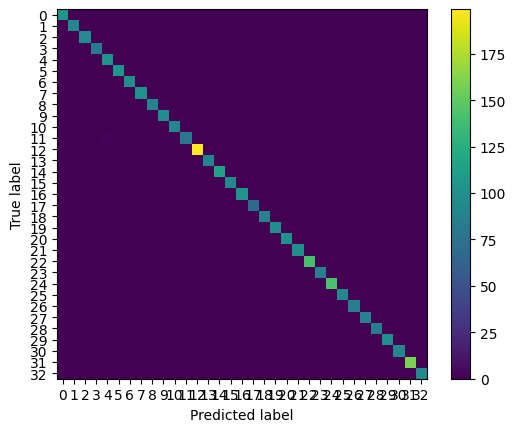

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

with torch.no_grad():
    loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    for batch in loader:
        X_batch, y_batch = batch
        print(f"X shape: {X_batch.shape}, y shape: {y_batch.shape}")
        y_pred = model(X_batch)
        y_pred_cls = np.argmax(y_pred.cpu().numpy(), axis=1)
        cm = confusion_matrix(y_batch.cpu().numpy(), y_pred_cls)
        ConfusionMatrixDisplay(cm).plot(include_values=False)
        break
# for batch, (X, y) in enumerate(loader):
#     # Compute prediction and loss
#     pred = model(X)
#     pred_cls = torch.argmax(pred)
#     print(pred_cls, y)


### Looks good let's try removing the diagonal to see what it gets wrong

X shape: torch.Size([3371, 2500]), y shape: torch.Size([3371])


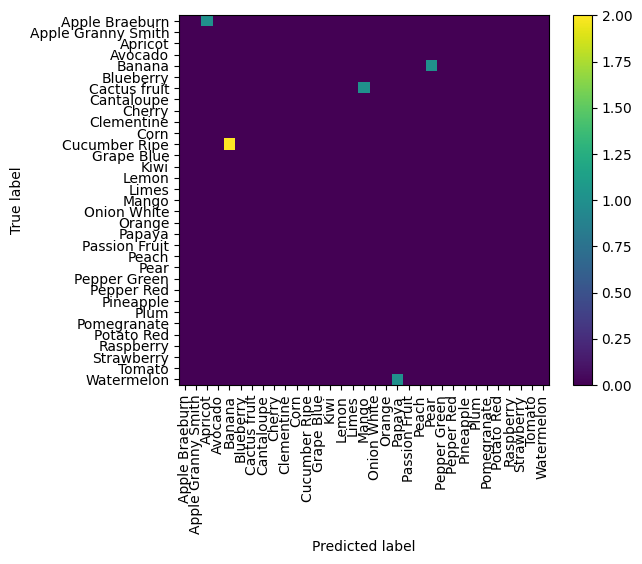

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

with torch.no_grad():
    loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    for batch in loader:
        X_batch, y_batch = batch
        print(f"X shape: {X_batch.shape}, y shape: {y_batch.shape}")
        y_pred = model(X_batch)
        y_pred_cls = np.argmax(y_pred.cpu().numpy(), axis=1)
        cm = confusion_matrix(y_batch.cpu().numpy(), y_pred_cls)
        np.fill_diagonal(cm, 0)
        ConfusionMatrixDisplay(
            cm, 
            display_labels=classes
        ).plot(include_values=False,
            xticks_rotation='vertical')
        break